# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from os import listdir
from os.path import isfile, join
dates=listdir('C:/Users/DR/Desktop/FE/Spring 2019/Algo/data')

In [3]:
stocks=listdir('C:/Users/DR/Desktop/FE/Spring 2019/Algo/data/'+dates[0])

In [4]:
f=open('labels.txt','w')
for name in stocks:
    f.write(name[6:-4].upper()+'\n')    
f.close()

Indicator Functions

In [6]:
def EMA(C):
    c = 1-1.0/5.0
    EMA=[C[0]]
    for i in range(1,len(C)):
        close =C[i]  
        ema = EMA[-1]*c+close*(1-c)
        EMA.append(ema)
    return np.array(EMA)

In [7]:
def MACD(C):
    a=1-2.0/11.0
    b=1-2.0/31.0
    ema_a = C[0]
    ema_b = C[0]
    EMA_a = [ema_a]
    EMA_b= [ema_b]
    for i in range(1,len(C)):
        close = C[i]  
        ema_a = EMA_a[-1]*a+close*(1-a)
        ema_b = EMA_b[-1]*b+close*(1-b)
        EMA_a.append(ema_a)
        EMA_b.append(ema_b)
    DIFF = np.array(EMA_a)-np.array(EMA_b)
    DEA=[DIFF[0]]
    c = 1-1.0/5.0
    for i in range(1,len(DIFF)):
        close =DIFF[i]  
        dea = DEA[-1]*c+close*(1-c)
        DEA.append(dea)
    MACD = 2*(DIFF-DEA)
    return np.array(MACD)

In [8]:
def RSI(C):
    hist=14
    RSI=[0]
    Ret=np.diff(C)/C[:-1]
    for i in range(1,len(C)):
        
        p=Ret[max(0,i-hist+1):i+1]
        pu=p[p>0]
        pd=p[p<0]

        if len(pd)==0:
            RSI.append(100)
        elif len(pu)==0:
            RSI.append(0)
        else:
            su=abs(np.mean(pu))
            sd=abs(np.mean(pd))
            rs=(su)/(sd)

            rsi=100-100.0/(1+rs)

            RSI.append(rsi)
            #print rsi
    RSI=np.array(RSI)
    return RSI

In [9]:
def SO(C,H,L):
    SO=[]
    hist=14
    for i in range(len(C)):

        c=C[i]
        h=max(H[max(0,i-hist+1):i+1])
        l=min(L[max(0,i-hist+1):i+1])
        k=100*(c-l)/(h-l)
        SO.append(k)
    SO=np.array(SO)
    return SO

In [10]:
def OBV(C,V):
    OBV=[V[0]]
    for i in range(1,len(C)):
        if C[i]>C[i-1]:
            OBV.append(OBV[-1]+V[i])
        elif C[i]<C[i-1]:
            OBV.append(OBV[-1]-V[i])
        else:
            OBV.append(OBV[-1])
    OBV=np.array(OBV)
    return OBV

In [11]:
def SMI(C,H,L):
    cm=[]
    hl=[]
    hist=14
    for i in range(len(C)):

        c=C[i]
        h=max(H[max(0,i-hist+1):i+1])
        l=min(L[max(0,i-hist+1):i+1])
        cm.append(c-(h+l)/2.0)
        hl.append(h-l)
    CM=EMA(EMA(cm))
    HL=EMA(EMA(hl))
    SMI=200*CM/HL
    
    return SMI

In [ ]:
Dict={}
for f in stocks:    
    O=[]
    C=[]
    H=[]
    L=[]
    V=[]
    Times=[]
    for d in dates:
        
        try:
            df=pd.read_csv('C:/Users/DR/Desktop/FE/Spring 2019/Algo/data/'+d+'/'+f,header=None)
            O.append(np.array(df[2])[0])
            C.append(np.array(df[5])[-1])
            H.append(np.max(df[3]))
            L.append(np.min(df[4]))
            V.append(np.sum(df[6]))
            Times.append(d[-8:])
        except: 
            pass
    Df=pd.DataFrame({'Date':Times,'Open':O,'Close':C,'High':H,'Low':L,'Volume':V})
    Df['MACD']=MACD(C)
    Df['RSI'] =RSI(C)
    Df['SO']=SO(C,H,L)
    Df['OBV']=OBV(C,V)
    Df['EMA']=EMA(C)
    Df['SMI']=SMI(C,H,L)
    Dict[f]=Df

In [265]:
Dict_={}
for s in Dict.keys():
    if len(np.array(Dict[s]))==63:
        Dict_[s[6:-4]]=Dict[s]

Saving files

In [269]:
np.save('data.npy',Dict_)

In [401]:
import pickle
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Dict_, f)

In [5]:
Dict_=np.load('data.npy').item()

In [6]:
f=open('labels.txt','w')
for name in Dict_.keys():
    f.write(name.upper()+'\n')    
f.close()

Visualization

In [14]:
def plot(name,data,s):
    plt.figure(figsize=(15,10))
    C=np.array(data[name][s])
    
    plt.plot(C)
    plt.title(name)


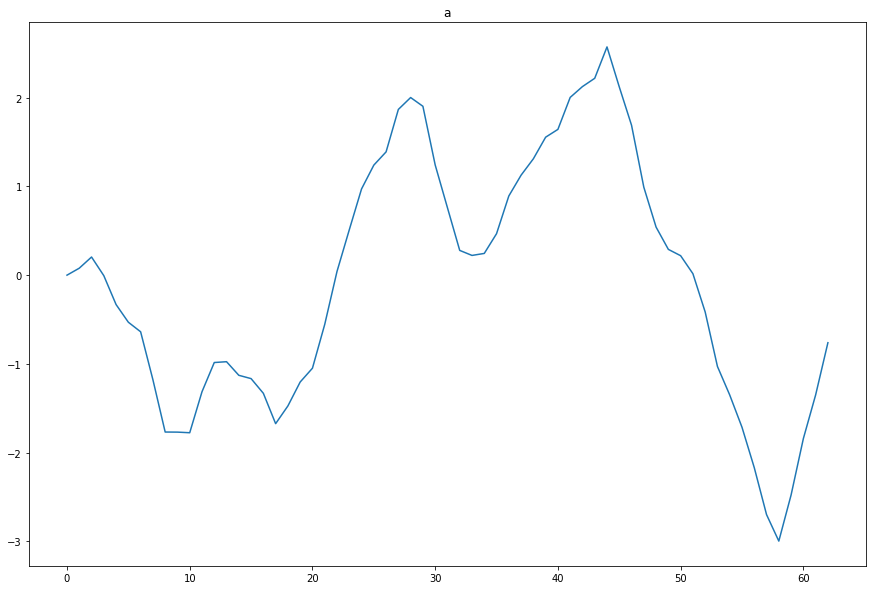

In [15]:
plot('a',Dict_,'MACD')

# Baseline Model

Testing on monthly rebalance:

In [7]:
#Rebalance Times
Dict_['a']['Date'][23],Dict_['a']['Date'][44],Dict_['a']['Date'][62]

('20181101', '20181203', '20181231')

In [17]:
#Select stocks that have the highest historical returns
pool_past={}
macd_past={}
pool_cur={}
macd_cur={}
pool_future={}
for name in Dict_.keys():
    #print(name)
    cur=Dict_[name]
    C=np.array(cur['Close'])
    O=np.array(cur['Open'])
    macd=np.array(cur['MACD'])
    past=(C[22]-O[0])/O[0]
    cur=(C[43]-O[23])/O[23]
    future=(C[62]-O[44])/O[44]
    pool_past[name]=past
    macd_past[name]=macd[22]
    pool_cur[name]=cur
    macd_cur[name]=macd[43]
    pool_future[name]=future

In [18]:
s=30
dd = sorted(pool_past.items(), key=lambda x: x[1],reverse=True)
pool1=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and macd_past[pair[0]]>0]
performance=sum([pool_cur[n] for n in pool1])/float(s)
benchmark=sum(pool_cur.values())/len(pool_cur.keys())

In [19]:
benchmark,performance

(0.016282695755074406, 0.040392785764703135)

In [20]:
print(pool1)

['mcd', 'hsy', 'tup', 'sjm', 'hcp', 'xlnx', 'atge', 'uaa', 'exr', 'f', 'spg', 'iff', 'etr', 'aep', 'ko', 'mrk', 'dltr', 'hrb', 'duk', 'scg', 'mmc', 'xrx', 'cmg', 'ice']


In [21]:
#Phase 2
dd = sorted(pool_cur.items(), key=lambda x: x[1],reverse=True)
pool2=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and macd_cur[pair[0]]>0]
performance=sum([pool_future[n] for n in pool2])/float(s)
benchmark=sum(pool_future.values())/len(pool_future.keys())

In [22]:
print(pool2)

['ghc', 'swk', 'see', 'uhs', 'mxim', 'dal', 'ehc', 'mlm', 'a', 'sci', 'aap', 'cmi', 'adsk', 'pwr', 'mdp', 'gnw', 'luv', 'clx', 'cvs', 'lrcx', 'dhr', 'xyl', 'cat', 'kmb', 'gww', 'aiv', 'ben']


In [23]:
benchmark,performance

(-0.12438698218471632, -0.09595958688856768)

We see that by selecting conservatively the second top tier stocks (size 20 and historic return positive) in the total 601 stocks that performed best in the respective test months
we usually get w pool that performs better than the baseline market average returns. For the month 11.01-11.31 we have a return of 0.0404 over 0.0163. For the month 12.03-12.31
we have a return of -0.096 over -0.1244. When selecting stocks we also add in a criterion that MACD values at the rebalance point must be positive for
us to add the stock into our buy long portfolio.


### Testing on Semi-monthly rebalance 

In [8]:
#Rebalance Times
testdates=[[Dict_['a']['Date'][11],Dict_['a']['Date'][22]]
           ,[Dict_['a']['Date'][23],Dict_['a']['Date'][33]]
           ,[Dict_['a']['Date'][34],Dict_['a']['Date'][43]]
           ,[Dict_['a']['Date'][44],Dict_['a']['Date'][52]]
           ,[Dict_['a']['Date'][53],Dict_['a']['Date'][62]]]

In [9]:
pool_p1={}
macd_p1={}
pool_p2={}
macd_p2={}
pool_p3={}
macd_p3={}
pool_p4={}
pool_p5={}
pool_p6={}
macd_p4={}
macd_p5={}
macd_p6={}
for name in Dict_.keys():
    #print(name)
    cur=Dict_[name]
    C=np.array(cur['Close'])
    O=np.array(cur['Open'])
    macd=np.array(cur['MACD'])
    pool_p1[name]=(C[10]-O[0])/O[0]
    macd_p1[name]=macd[10]
    pool_p2[name]=(C[22]-O[10])/O[10]
    macd_p2[name]=macd[22]
    pool_p3[name]=(C[33]-O[23])/O[23]
    macd_p3[name]=macd[33]
    pool_p4[name]=(C[43]-O[34])/O[34]
    macd_p4[name]=macd[43]
    pool_p5[name]=(C[52]-O[44])/O[44]
    macd_p5[name]=macd[52]
    pool_p6[name]=(C[62]-O[53])/O[53]
    

In [10]:
s=30
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
M=[macd_p1,macd_p2,macd_p3,macd_p4,macd_p5,macd_p6]
for i in range(5):
    dd = sorted(P[i].items(), key=lambda x: x[1],reverse=True)
    pool1=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and M[i][pair[0]]>0]
    performance=sum([P[i+1][n] for n in pool1])/float(s)
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(benchmark,performance)

-0.01874447243820561 0.012470635421340893
0.00958486895368256 -0.005095582885597492
0.008820059157016264 0.008668956915780204
-0.08420009378968411 -0.0790157009478927
-0.04260201275399443 -0.03327840588916


# NN Model

Monthly Rebalance

In [39]:
data=[]
data_out=[]
phase_1={}
X_one=[]
for name in Dict_.keys():
    cur=Dict_[name]
    C=np.array(cur['Close'])
    h=14
    for i in range(h,len(C)-h):
        vec=[]
        for j in ['EMA','MACD','SMI','SO','RSI']:
            vec+=list(np.array(cur[j])[i-h+1:i+1])
        vec.append((C[i]-C[i-h])/C[i-h])
        vec.append((C[i+h]-C[i])/C[i])
        data.append(vec)
        if i==43:
            data_out.append(vec)
        if i==22:
            X_one.append(vec[:-1])
            phase_1[name]=vec[-1]

In [13]:
from keras.models import Sequential
from keras.layers import Dense
data=np.array(data)
import numpy as np
#np.random.seed(1)
np.random.shuffle(data)
size=int(0.8*len(data))
X_train=data[0:size,0:-1]
y_train=data[0:size,-1]
X_test=data[size:,0:-1]
y_test=data[size:,-1]

Using TensorFlow backend.


In [41]:
data_out=np.array(data_out)
X_out=data_out[:,0:-1]
y_out=data_out[:,-1]

In [123]:
from sklearn.ensemble import RandomForestClassifier
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(30,activation='sigmoid'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [124]:
model.fit(X_train,y_train,epochs=100,batch_size=1000)

Epoch 1/100
16828/16828 [==============================] - 0s 24us/step - loss: 0.0216
Epoch 2/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0109
Epoch 3/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0094
Epoch 4/100
16828/16828 [==============================] - 0s 4us/step - loss: 0.0087
Epoch 5/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0083
Epoch 6/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0080
Epoch 7/100
16828/16828 [==============================] - 0s 4us/step - loss: 0.0078
Epoch 8/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0076
Epoch 9/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0074
Epoch 10/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0073
Epoch 11/100
16828/16828 [==============================] - 0s 5us/step - loss: 0.0072
Epoch 12/100
16828/16828 [=========================

In [125]:
model.evaluate(X_test,y_test)

4207/4207 [==============================] - 0s 55us/step


0.006349568225968907

In [258]:
model.evaluate(X_out,y_out)

NameError: name 'model' is not defined

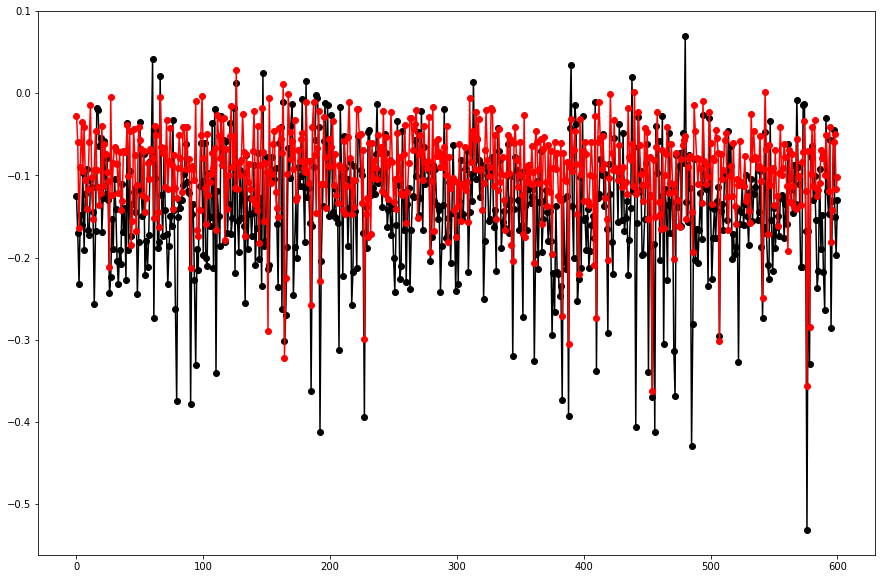

In [127]:
y_p=model.predict(X_out)
plt.figure(figsize=(15,10))
plt.plot(y_out,'ko-')
plt.plot(y_p,'ro-')

Performance Over Two Month Rebalancing

In [128]:
pool_out={}
pool_pred={}
y_pred=model.predict(X_out)
for i in range(len(Dict_.keys())):
    pool_out[list(Dict_.keys())[i]]=y_out[i]
    pool_pred[list(Dict_.keys())[i]]=y_pred[i]

In [129]:
s=20
dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
pool=[pair[0] for pair in dd[0:s] if pair[1]>0]
performance=sum([pool_future[n] for n in pool])/float(s)
benchmark=sum(pool_future.values())/len(pool_future.keys())

In [130]:
#1203-1231
print(pool)
benchmark,performance

['cnp', 'dnb', 'udr', 'ppl']


(-0.12438698218471632, -0.007018709110251925)

In [131]:
pool_one={}
y_one=model.predict(np.array(X_one))
for i in range(len(Dict_.keys())):
    pool_one[list(Dict_.keys())[i]]=y_one[i]
s=20
dd = sorted(pool_one.items(), key=lambda x: x[1],reverse=True)
pool=[pair[0] for pair in dd[0:s] if pair[1]>0]
performance=sum([pool_cur[n] for n in pool])/float(s)
benchmark=sum(pool_cur.values())/len(pool_cur.keys())   

In [132]:
#1101-1131
print(pool)
benchmark,performance

['mhk', 'wdc', 'nwl', 'emn', 'ibm', 'vc', 'tup', 'cck', 'pfg', 'apc', 'pnr', 'nclh', 'bgg', 'etn', 'cl', 'sanm', 'un', 'ph', 'xec', 'xrx']


(0.016282695755074406, 0.07275474163394016)

With a Neural Network with only fully connected layers we can pass in the entire historic indicator values and returns over the past 14 days and predict this future period return accordingly.
The predicted returns will be used in place of the historic returns to select the top 20 stocks aggressively and test using the same time periods.
We still only select stocks that have a positive predicted returns. The 11.01-11.31 results improved to 0.0728 over 0.0404 benchmark. The 12.03-12.31 result
improves to -0.007 over the -0.096 benchmark.

### Semi-monthly Rebalance

In [73]:
data=[]
p1=[]
p2=[]
p3=[]
p4=[]
p5=[]
for name in Dict_.keys():
    cur=Dict_[name]
    C=np.array(cur['Close'])
    h=10
    for i in range(h,len(C)-h):
        vec=[]
        for j in ['EMA','MACD','SMI','SO','RSI','Close']:
            vec+=list(np.array(cur[j])[i-h+1:i+1])
        #vec.append((C[i]-C[i-h])/C[i-h])
        vec.append((C[i+h]-C[i])/C[i])
        if i!=52:
            data.append(vec)
        if i==10:
            p1.append(vec[:-1])
        elif i==22:
            p2.append(vec[:-1])
        elif i==33:
            p3.append(vec[:-1])
        elif i==43:
            p4.append(vec[:-1])
        elif i==52:
            p5.append(vec[:-1])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data=np.array(data)
#data=scaler.fit_transform(data)
np.random.shuffle(data)
size=int(0.8*len(data))
X_train=data[0:size,0:-1]
y_train=data[0:size,-1]
X_test=data[size:,0:-1]
y_test=data[size:,-1]



In [90]:
model_2 = Sequential()
model_2.add(Dense(100, input_dim=X_train.shape[1], activation='sigmoid'))
model_2.add(Dense(20,activation='sigmoid'))
model_2.add(Dense(1))

model_2.compile(loss='mean_squared_error', optimizer='adam')

In [91]:

history=model_2.fit(X_train,y_train,validation_split=0.2,epochs=150,batch_size=1000,verbose=1)

Train on 16154 samples, validate on 4039 samples
Epoch 1/150
16154/16154 [==============================] - 0s 27us/step - loss: 0.3480 - val_loss: 0.1033
Epoch 2/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0439 - val_loss: 0.0142
Epoch 3/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0133 - val_loss: 0.0090
Epoch 4/150
16154/16154 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0084
Epoch 5/150
16154/16154 [==============================] - 0s 7us/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0078 - val_loss: 0.0079
Epoch 7/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0076 - val_loss: 0.0077
Epoch 8/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0074 - val_loss: 0.0075
Epoch 9/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0072 - val_loss: 0.0074
Epoch

16154/16154 [==============================] - 0s 5us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 78/150
16154/16154 [==============================] - 0s 7us/step - loss: 0.0053 - val_loss: 0.0057
Epoch 79/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 80/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 81/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 82/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 83/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 84/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 85/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0053 - val_loss: 0.0056
Epoch 86/150
16154/16154 [==============================] -

In [92]:
model_2.evaluate(X_test,y_test)

5049/5049 [==============================] - 0s 22us/step


0.005916354044641769

In [93]:
from sklearn.metrics import r2_score

In [94]:
y_pre=model_2.predict(X_train)
#y_p=model_2.predict(X_test)
#r2_score(y_test,y_p),
r2_score(y_train,y_pre)

0.22120509380526643

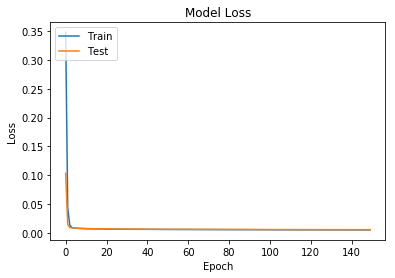

In [95]:

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [96]:
s=20
print('Period                 Index                      Benchmark')
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
M=[macd_p1,macd_p2,macd_p3,macd_p4,macd_p5,macd_p6]
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    dd = sorted(P[i].items(), key=lambda x: x[1],reverse=True)
    pool1=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and M[i][pair[0]]>0]
    performance=sum([P[i+1][n] for n in pool1])/float(s)
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance)

Period                 Index                      Benchmark
20181016-20181031 -0.01874447243820561 0.0018272913752329894
20181101-20181115 0.00958486895368256 0.01321792582011581
20181116-20181130 0.008820059157016264 -0.0017875242688114193
20181203-20181214 -0.08420009378968411 -0.0858061922137702
20181217-20181231 -0.04260201275399443 -0.03762336472178846


In [97]:
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H=[p1,p2,p3,p4,p5]
Long=[]
print('Period                  Index                NN Balanced                  NN Weighted')
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    pool_pred={}
    y_pred=model_2.predict(np.array(H[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    s=20
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool=[pair[0] for pair in dd[0:s] if pair[1]>0]
    mu=[pair[1][0] for pair in dd[0:s] if pair[1]>0]
    Long.append((pool,mu))
    performance=sum([P[i+1][n] for n in pool])/float(len(pool))
    performance2=sum([P[i+1][n]*pool_pred[n][0] for n in pool])/float(np.sum(mu));
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance,performance2)

Period                  Index                NN Balanced                  NN Weighted
20181016-20181031 -0.01874447243820561 0.04382710073100828 0.05285958250948853
20181101-20181115 0.00958486895368256 0.04577343961148787 0.04646318665169146
20181116-20181130 0.008820059157016264 0.008156944042465714 0.007754009027807398
20181203-20181214 -0.08420009378968411 -0.03833247158435071 -0.045225643416775756
20181217-20181231 -0.04260201275399443 -0.037161334639139516 -0.03780511838466882


In [98]:
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H=[p1,p2,p3,p4,p5]
print('Index                     NN L&S')
for i in range(5):
    pool_pred={}
    y_pred=model_2.predict(np.array(H[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    s=20
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool_l=[pair[0] for pair in dd[0:s] if pair[1]>0]
    pool_s=[pair[0] for pair in dd[-s:] if pair[1]<0]
    #print('Long:')
    #print(pool_l)
    #print('Short:')
    #print(pool_s)
    performance=(-sum([P[i+1][n] for n in pool_s])+sum([P[i+1][n] for n in pool_l]))/float(len(pool_l)+len(pool_s))
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(benchmark,performance)

Index                     NN L&S
-0.01874447243820561 0.08553714596870396
0.00958486895368256 0.055104400332864636
0.008820059157016264 0.044555083751844395
-0.08420009378968411 0.06537967060779784
-0.04260201275399443 0.030780713310408415


Another Model With different architecture

In [102]:
data2=[]
q1=[]
q2=[]
q3=[]
q4=[]
q5=[]
for name in Dict_.keys():
    cur=Dict_[name]
    C=np.array(cur['Close'])
    h=11
    for i in range(h-1,len(C)-10):
        vec=[]
        for j in ['EMA','MACD','SMI','SO','RSI','Close']:
            vec+=list(np.array(cur[j])[i-h+1:i+1])
        #vec.append((C[i]-C[i-h])/C[i-h])
        vec.append((C[i+10]-C[i])/C[i])
        if i!=52:
            data2.append(vec)
        if i==10:
            q1.append(vec[:-1])
        elif i==22:
            q2.append(vec[:-1])
        elif i==33:
            q3.append(vec[:-1])
        elif i==43:
            q4.append(vec[:-1])
        elif i==52:
            q5.append(vec[:-1])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data2=np.array(data2)
#data=scaler.fit_transform(data)
np.random.shuffle(data2)
size=int(0.8*len(data2))
X_train2=data2[0:size,0:-1]
y_train2=data2[0:size,-1]
X_test2=data2[size:,0:-1]
y_test2=data2[size:,-1]



In [110]:
model_3 = Sequential()
model_3.add(Dense(100, input_dim=X_train2.shape[1], activation='sigmoid'))
model_3.add(Dense(60,activation='sigmoid'))
model_3.add(Dense(20,activation='sigmoid'))
model_3.add(Dense(1))

model_3.compile(loss='mean_squared_error', optimizer='adam')

In [111]:
history=model_3.fit(X_train2,y_train2,validation_split=0.2,epochs=150,batch_size=2000,verbose=1)

Train on 16154 samples, validate on 4039 samples
Epoch 1/150
16154/16154 [==============================] - 0s 31us/step - loss: 0.0235 - val_loss: 0.0074
Epoch 2/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0100 - val_loss: 0.0068
Epoch 3/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0078 - val_loss: 0.0066
Epoch 4/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 6/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0060 - val_loss: 0.0062
Epoch 7/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0059 - val_loss: 0.0062
Epoch 8/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0058 - val_loss: 0.0061
Epoch 9/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0057 - val_loss: 0.0061
Epoch

Epoch 78/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0048 - val_loss: 0.0056
Epoch 79/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 80/150
16154/16154 [==============================] - 0s 7us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 81/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 82/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 83/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0047 - val_loss: 0.0055
Epoch 84/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 85/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0047 - val_loss: 0.0055
Epoch 86/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0047 - val_loss: 0.0055
Epoch 87/150
16154/16154 [====================

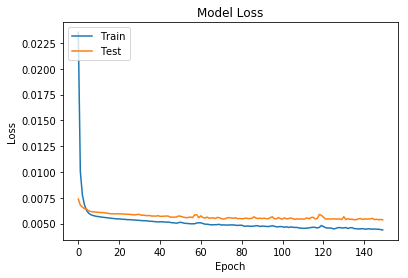

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [113]:
model_3.evaluate(X_test2,y_test2)

5049/5049 [==============================] - 0s 27us/step


0.005486141820608829

In [114]:
y_pre2=model_3.predict(X_train2)
y_p2=model_3.predict(X_test2)
r2_score(y_test2,y_p2),r2_score(y_train2,y_pre2)

(0.15501946490416385, 0.288678185861154)

In [115]:
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H2=[q1,q2,q3,q4,q5]
Long=[]
print('Period              Index                NN Balanced                  NN Weighted')
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    pool_pred={}
    y_pred=model_3.predict(np.array(H2[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    s=20
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool=[pair[0] for pair in dd[0:s] if pair[1]>0]
    mu=[pair[1][0] for pair in dd[0:s] if pair[1]>0]
    Long.append((pool,mu))
    performance=sum([P[i+1][n] for n in pool])/float(len(pool))
    performance2=sum([P[i+1][n]*pool_pred[n][0] for n in pool])/float(np.sum(mu));
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance,performance2)

Period              Index                NN Balanced                  NN Weighted
20181016-20181031 -0.01874447243820561 0.008713255554173484 0.01870377008946259
20181101-20181115 0.00958486895368256 0.07328915200829887 0.07239939217986273
20181116-20181130 0.008820059157016264 0.02187881594274469 0.01760863020823628
20181203-20181214 -0.08420009378968411 -0.056034096426600344 -0.036133326241445926
20181217-20181231 -0.04260201275399443 -0.03822083657126945 -0.04181519789816597


In [116]:

print('Period               Index                     NN L&S')
for i in range(5):
    pool_pred={}
    period=testdates[i][0]+'-'+testdates[i][1]
    y_pred=model_3.predict(np.array(H2[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    s=20
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool_l=[pair[0] for pair in dd[0:s] if pair[1]>0]
    pool_s=[pair[0] for pair in dd[-s:] if pair[1]<0]
    #print('Long:')
    #print(pool_l)
    #print('Short:')
    #print(pool_s)
    performance=(-sum([P[i+1][n] for n in pool_s])+sum([P[i+1][n] for n in pool_l]))/float(len(pool_l)+len(pool_s))
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance)

Period               Index                     NN L&S
20181016-20181031 -0.01874447243820561 0.07950869988606223
20181101-20181115 0.00958486895368256 0.07539857530160865
20181116-20181130 0.008820059157016264 0.03862810931605332
20181203-20181214 -0.08420009378968411 0.05574385839811578
20181217-20181231 -0.04260201275399443 0.025301983962481945


# Markowitz Portfolio (TODO)

In [227]:
port1=Long[4][0]
mu=Long[4][1]
D=[]
for n in port1:
    C=np.array(Dict_[n]['Close'])[:53]
    R=[(C[i+1]-C[i])/C[i] for i in range(len(C)-1)]
    D.append(R)
V=np.cov(D)

In [228]:
np.savetxt('p1mean.txt',np.array(mu)/10.0)
np.savetxt('p1cov.txt',V)

In [229]:
w2=np.loadtxt('P2weights.txt')

In [230]:
np.sum([P[5][port1[i]]*w2[i] for i in range(len(w2))])

-0.09404203269727765

In [232]:
np.sum([P[5][n] for n in port1])/float(len(port1))

-0.03628447436323676